# Initialization

In [67]:
import os
import grasp
import numpy as np
from astropy import units as u
from matplotlib import pyplot as plt
dr3 = grasp.dr3()
gc = grasp.Cluster('ngc6121')

try:
    device_name = os.getenv('COMPUTERNAME')
    if device_name == 'DESKTOP-Work':
        tn1 = '20250402_204446'
        tn2 = '20250402_204448'
        acs = grasp.load_data(tn1)
        pcs = grasp.load_data(tn2)
    elif device_name == 'LAPTOP-Work':
        tn1 = '20250401_164228'
        tn2 = '20250401_164231'
        pcs = grasp.load_data(tn1)
        acs = grasp.load_data(tn2)
    else:
        raise EnvironmentError("Unknown device name")
except Exception:
    astrometry_query = "SELECT source_id, ra, ra_error, dec, dec_error, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, \
                        radial_velocity, radial_velocity_error, bp_rp, phot_g_mean_mag, phot_bp_mean_mag, phot_rp_mean_mag, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.897,-26.526,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND abs(parallax_error/parallax)<0.50\
                        AND abs(pmra_error/pmra)<0.30 \
                        AND abs(pmdec_error/pmdec)<0.30 \
                        AND pmra IS NOT NULL AND abs(pmra)>0 \
                        AND pmdec IS NOT NULL AND abs(pmdec)>0 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.214805 AND -17.807517"
    
    photometry_query = "SELECT source_id, ra, ra_error, dec_error, dec, parallax, parallax_error, pmra, pmra_error, pmdec, pmdec_error, radial_velocity, radial_velocity_error, \
                        bp_rp, phot_g_mean_mag, phot_bp_rp_excess_factor, teff_gspphot, ra_dec_corr, pmra_pmdec_corr \
                        FROM gaiadr3.gaia_source \
                        WHERE CONTAINS(POINT('ICRS',gaiadr3.gaia_source.ra,gaiadr3.gaia_source.dec),CIRCLE('ICRS',245.8958,-26.5256,0.86))=1 \
                        AND parallax IS NOT NULL AND parallax>0.531632110579479 AND parallax<0.5491488193300\
                        AND ruwe < 1.15 \
                        AND phot_g_mean_mag > 11 \
                        AND astrometric_excess_noise_sig < 2 \
                        AND pmra BETWEEN -13.742720 AND -11.295338 \
                        AND pmdec BETWEEN -20.2148 AND -17.807517"
    
    acs = dr3.free_query(astrometry_query, save=True)
    acs = grasp.Sample(acs, gc)
    pcs = dr3.free_query(photometry_query, save=True)
    pcs = grasp.Sample(pcs, gc)
    print("\nWARNING! Remember to updates tn after running the new query!!!")


GAIA - GLOBULAR CLUSTERS ANALYSIS SOFTWARE
            ..............
         ..:;;..:;;;;;:::::;;
       ;;;;;;::.::;;;;;;;;;;;;;
      ;;;;.:;;;..;XXXXXX.::....:
     :;::;::..+XXXXXXXXX+:;;;;;;:
    ;::;:.:;;:XXXXXXXXXXX::::::::;        __ _  __ _(_) __ _
    .;;..;;;:.:XXXXXXXXX$$$$$$$$$$X.     / _` |/ _` | |/ _` |
    :;..:;;;..:xXXXXXXX$$$$$$$$$$$$X    | (_| | (_| | | (_| |
    :;:.:;;.XXXXXXXXX$$$$$$$$$$$$$$;     \__, |\__,_|_|\__,_|
    .;;:.:X$$$$$$$$$$$$$$$$$$$$$$X.      |___/
    ..:;:$$$$$$$$$$$$$$$$$$$$$$X;.
     :;;;$$$$$$$$$$$$$$$$$$$$::;;
      ...;$$$$$$$$$$$$$$x;:;;;;;
        ......:;:....;;;;;;;:.
         ::::::::::;;;::...

             INITIALIZED


Initialized with Gaia table: 'gaiadr3.gaia_source'


In [ ]:
aps = acs.join(pcs)
aps.gc.dist = 1851 * u.pc # Baumgardt, Vasiliev: 2021 # pc
f = grasp.load_base_formulary()
aps.info()

<QTable length=1014>
          name            dtype     class     n_bad
------------------------ ------- ------------ -----
               SOURCE_ID   int64       Column     0
                      ra float64       Column     0
                ra_error float64       Column     0
                     dec float64       Column     0
               dec_error float64       Column     0
                parallax float64       Column     0
          parallax_error float64       Column     0
                    pmra float64       Column     0
              pmra_error float64       Column     0
                   pmdec float64       Column     0
             pmdec_error float64       Column     0
         radial_velocity float64 MaskedColumn   923
   radial_velocity_error float64 MaskedColumn   923
                   bp_rp float64 MaskedColumn    31
         phot_g_mean_mag float64 MaskedColumn     1
        phot_bp_mean_mag float64 MaskedColumn   118
        phot_rp_mean_mag float64 MaskedColu

# Data visualization

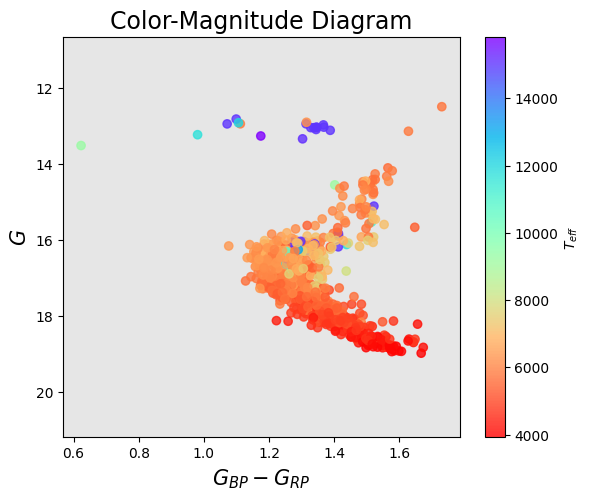

In [69]:
grasp.plots.colorMagnitude(aps)

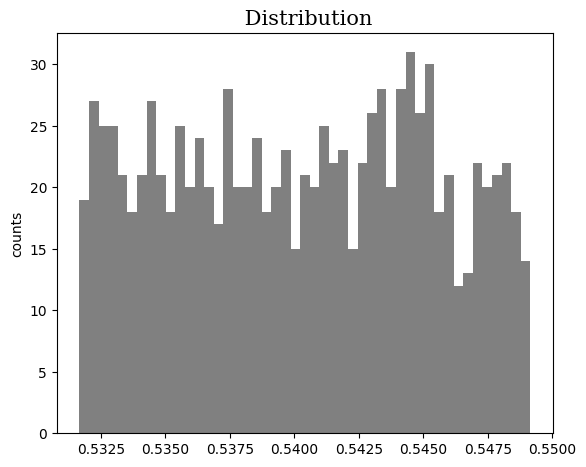

In [70]:
grasp.plots.histogram(aps.parallax)

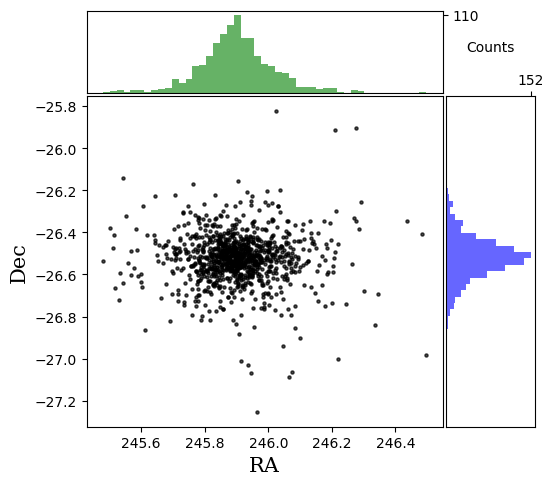

In [71]:
grasp.plots.doubleHistScatter(aps.ra, aps.dec, xlabel='RA', ylabel='Dec')

# Angular Separation Analysis

The `Great Circle` formula versus the `Vincenty Formula` for the computation of distances on a sphere

## $\theta_V$   vs   $\theta_{GC}$

In [ ]:
f.substitute('Angular separation', {'alpha_{0}': aps.gc.ra.to(u.rad).value, 'delta_{0}':aps.gc.dec.to(u.rad).value})

from sympy import atan2
atan_arg_1 = 'sqrt((cos(delta_1) * sin((alpha_0 - alpha_1)/2))**2 + (cos(delta_0)*sin(delta_1) - sin(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2 ))**2)'
atan_arg_2 = '(sin(delta_0)*sin(delta_1) + cos(delta_0)*cos(delta_1)*cos((alpha_0 - alpha_1)/2))'
atan = atan2(atan_arg_1, atan_arg_2)
f.add_formula('Vincenty angsep', atan)
f.substitute('Vincenty angsep', {'alpha_0': aps.gc.ra.to(u.rad).value, 'delta_0':aps.gc.dec.to(u.rad).value})


f.angular_separation

Eq(theta, 2*asin(sqrt(0.894734909182543*sin(alpha_{1}/2 - 2.14584566341274)**2*cos(delta_{1}) + sin(delta_{1}/2 + 0.231479528033504)**2)))

In [95]:
f['Vincenty angsep']

Eq(f_0, atan2(sqrt(0.800550557709893*(sin(delta_1) + 0.499139604910561*cos(delta_1)*cos(alpha_1/2 - 2.14584566341274))**2 + sin(alpha_1/2 - 2.14584566341274)**2*cos(delta_1)**2), -0.446597629069061*sin(delta_1) + 0.894734909182543*cos(delta_1)*cos(alpha_1/2 - 2.14584566341274)))

In [96]:
f.var_order('Angular Separation')
print('')
f.var_order('Vincenty angsep')


`Angular separation' variables must be passed in the following order:
Data         : [alpha_{1}, delta_{1}]
Errors       : [epsilon_alpha_{1}, epsilon_delta_{1}]
Correlations : [rho_alpha_{1}_delta_{1}]


`Vincenty angsep' variables must be passed in the following order:
Data         : [alpha_1, delta_1]
Errors       : [epsilon_alpha_1, epsilon_delta_1]
Correlations : [rho_alpha_1_delta_1]


Great Circle Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_{1}, delta_{1}]
Computation using all 16 cores.

Vincenty Distance computation

WARNING! Be sure that the input data follow this specific order: 
Data:         [alpha_1, delta_1]
Computation using all 16 cores.


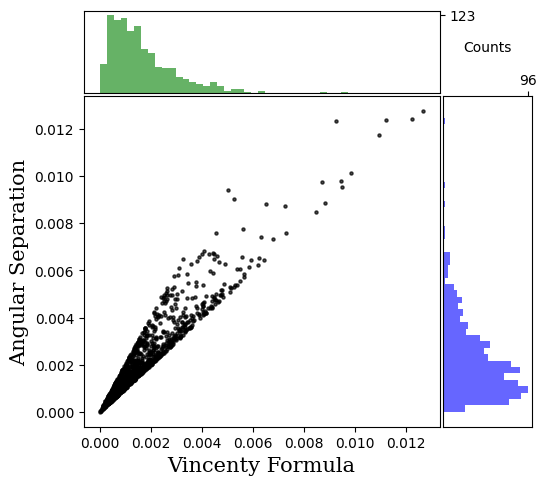

In [97]:
ra, dec = ((aps.ra * u.deg).to(u.rad).value, (aps.dec * u.deg).to(u.rad).value)
print("Great Circle Distance computation\n")
theta_1 = f.compute('Angular Separation', data={'alpha_{1}': ra, 'delta_{1}': dec}, asarray=True)
print("\nVincenty Distance computation\n")
theta_2 = f.compute('Vincenty angsep', data={'alpha_1': ra, 'delta_1': dec}, asarray=True)

grasp.plots.doubleHistScatter(theta_2, theta_1, xlabel='Vincenty Formula', ylabel='Angular Separation')

Correctly imported `minpack.lm`.


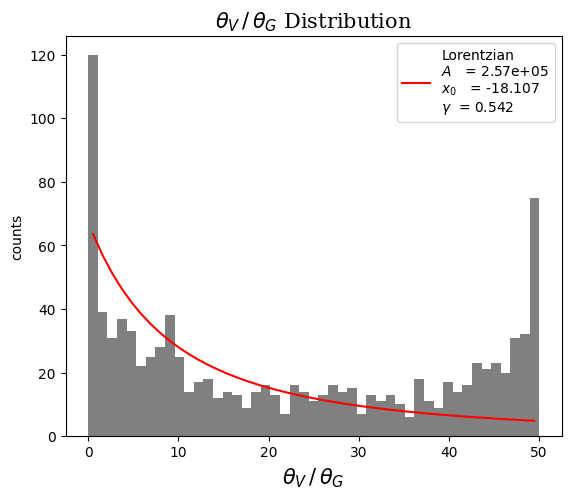

A = 256543.27  ;  lambda = -18.11


In [98]:
t_ratio = theta_2/theta_1
err_t = (1-t_ratio) * 100
out = grasp.plots.histogram(err_t, kde=True, kde_kind='lorentzian', xlabel=r'$\theta_V\,/\,\theta_G$', out=True)
fit = out['kde']
print(f"A = {fit[0]:.2f}  ;  lambda = {fit[1]:.2f}")

## $r_{2D}(\theta_V)$ vs $r_{2D}(\theta_{GC})$

In [ ]:
f.substitute('radial_distance_2d', {'r_{c}': aps.gc.dist.value})
f.radial_distance_2d

Eq(r_{2}, 1851.0*tan(theta))

In [100]:
f.var_order('radial_distance_2d')


`Radial distance 2d' variables must be passed in the following order:
Data         : [theta]
Errors       : [epsilon_theta]
Correlations : None


In [101]:
print(r'Computation using $\theta_{GC}$')
r2d_1 = f.compute('radial_distance_2d', data={'theta': theta_1}, asarray=True) # Great Circle
print('')
print(r'Computation using $\theta_{V}$')
r2d_2 = f.compute('radial_distance_2d', data={'theta': theta_2}, asarray=True) # Vincenty Formula

r_ratio = r2d_2/r2d_1

Computation using $\theta_{GC}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Computation using all 16 cores.

Computation using $\theta_{V}$
WARNING! Be sure that the input data follow this specific order: 
Data:         [theta]
Computation using all 16 cores.


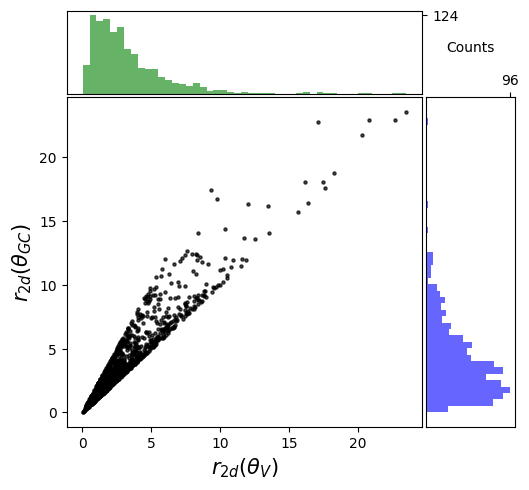

In [102]:
grasp.plots.doubleHistScatter(r2d_2, r2d_1, xlabel=r'$r_{2d}(\theta_{V})$', ylabel=r'$r_{2d}(\theta_{GC})$')

Correctly imported `minpack.lm`.


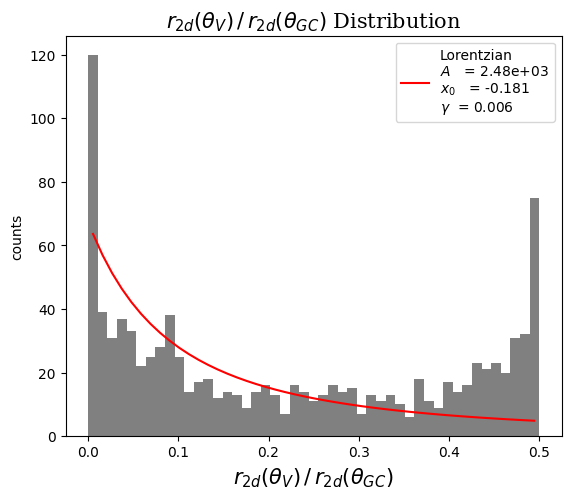

In [103]:
grasp.plots.histogram(1-r_ratio[r_ratio<400], kde=True, kde_kind='lorentzian', xlabel=r'$r_{2d}(\theta_{V})\,/\,r_{2d}(\theta_{GC})$')

In [104]:
reg_e = grasp.stats.regression(r_ratio[r_ratio<400], 'exponential', False)
reg_p = grasp.stats.regression(r_ratio[r_ratio<400], 'power', False)

Correctly imported `minpack.lm`.
Correctly imported `minpack.lm`.


# Radial Distance $R$

### Computing $d$ and $r_x$

In [105]:
f.los_distance

Eq(r_{x}, 1/omega)

In [106]:
f.gc_z_coordinate


Eq(d, -r_{c} + r_{x})

In [107]:
f.radial_distance_3d

Eq(R, sqrt(d**2 + r_{2}**2))

In [108]:
rt_pc = np.tan(aps.gc.rt.to(u.rad).value) * aps.gc.dist.to(u.pc)
print(f"Tidal radius of {aps.gc.id} = {rt_pc:.2f}")

Tidal radius of NGC6121 = 27.90 pc


In [109]:
f.var_order('los_distance')
f.var_order('gc_z_coordinate')
f.substitute('gc_z_coordinate', {'r_{c}': aps.gc.dist.value})
print('')
r_x = f.compute('los_distance', data={'omega': aps.parallax}, asarray=True) * 1000
print('')
d = f.compute('gc_z_coordinate',data={'r_{x}': r_x}, asarray=True)


`Los distance' variables must be passed in the following order:
Data         : [omega]
Errors       : [epsilon_omega]
Correlations : None

`Gc z coordinate' variables must be passed in the following order:
Data         : [r_{c}, r_{x}]
Errors       : [epsilon_r_{c}, epsilon_r_{x}]
Correlations : [rho_r_{c}_r_{x}]

WARNING! Be sure that the input data follow this specific order: 
Data:         [omega]
Computation using all 16 cores.



WARNING! Be sure that the input data follow this specific order: 
Data:         [r_{x}]
Computation using all 16 cores.


### $R(\theta_V)$

In [110]:
f.var_order('radial_distance_3d')


`Radial distance 3d' variables must be passed in the following order:
Data         : [d, r_{2}]
Errors       : [epsilon_d, epsilon_r_{2}]
Correlations : [rho_d_r_{2}]


WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 16 cores.


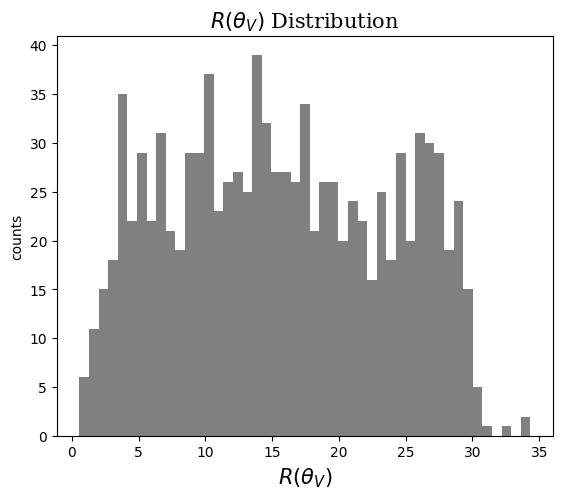

In [111]:
R_V = f.compute('radial_distance_3d', data={'d': d,'r_{2}': r2d_2,}, asarray=True)
grasp.plots.histogram(R_V, xlabel=r'$R(\theta_V)$')

### $R(\theta_{GC}$)

WARNING! Be sure that the input data follow this specific order: 
Data:         [d, r_{2}]
Computation using all 16 cores.
Correctly imported `minpack.lm`.


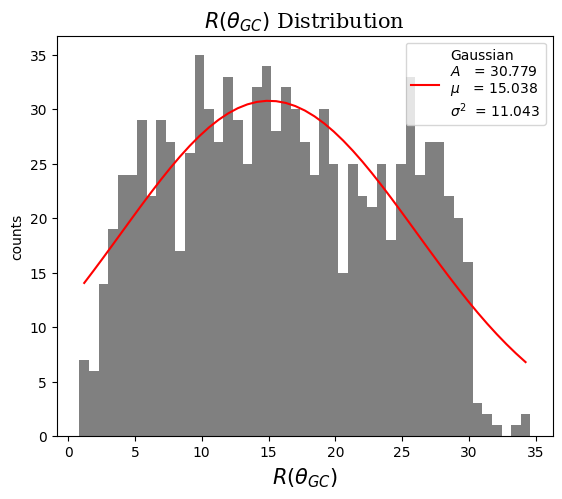

In [112]:
R_GC = f.compute('radial_distance_3d', {'d': d,'r_{2}': r2d_1,}, asarray=True)
rgc_hist = grasp.plots.histogram(R_GC, xlabel=r'$R(\theta_{GC})$', kde=True, kde_kind='gaussian', out=True, kde_verbose=False)

### $R(\theta_V)$ vs $R(\theta_{GC})$

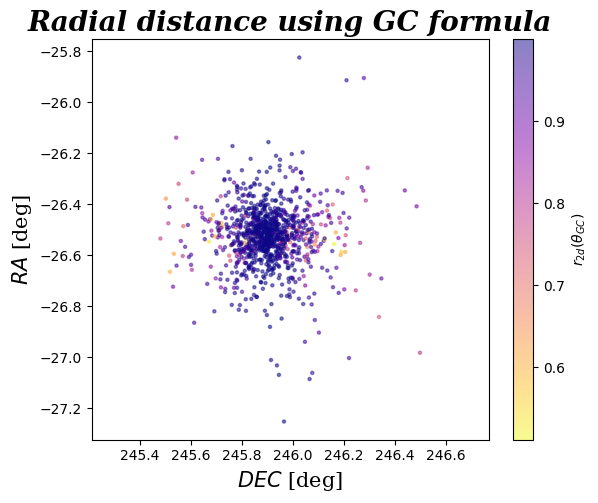

In [113]:
grasp.plots.spatial(aps, color=R_V/R_GC, colorbar=True, colorbar_label=r'$r_{2d}(\theta_{GC})$', cmap='plasma_r', title='Radial distance using GC formula')

In [114]:
print(f"ratio mean = {np.mean(R_V/R_GC):.2f} ; ratio std = {np.std(R_V/R_GC):.2f}")

ratio mean = 0.96 ; ratio std = 0.08


**Conclusions**

The vincenty formula computes the angular separation between two points on an ellipsoid, so, in the case of computing<br>
angular separations between stars in the celestial sphere, which geometry is, effectively, a unit sphere, the Great Circle<br>
formula is the correct one to use, as it computes the distances on a spheric geometry<br>

*Overall*, defined the ratio 

> $\bar{r} = \dfrac{R(\theta_{V})}{R(\theta_{GC})}$

its mean and standard deviation

> $\big<\bar{r}\big> = 0.96$

> $\sigma(\bar{r}) = 0.08$

indicates that, for the problem at hand, the two equations provide almost equal results, provided some outlier data.

In the end, using the GC formula is recommended, as it is computed on the actual geometry we are considering

### Ulterior analysis with cartesian coordinate transformations

In [115]:
from grasp.functions import CartesianConversion
import sympy as sp
ra0 ,dec0 = sp.symbols('ra_0 dec_0')

cv = CartesianConversion(aps.gc.ra.value, aps.gc.dec.value)

IndexError: list index out of range

In [ ]:
for i in range(0,11,2):
    print( i , i+1)

0 1
2 3
4 5
6 7
8 9
10 11


In [ ]:
f.vincenty_angsep

Eq(f_0, atan2(sqrt(0.968670974831493*(0.179839587367255*sin(delta_1) + cos(delta_1)*cos(alpha_1/2 - 122.9479))**2 + cos(delta_1*sin(alpha_1/2 - 122.9479))**2), -0.984210838607*sin(delta_1) + 0.177000071097462*cos(delta_1)*cos(alpha_1/2 - 122.9479)))

# Dynamics 

### PMRA ($\mu_\alpha$) mean

Correctly imported `minpack.lm`.


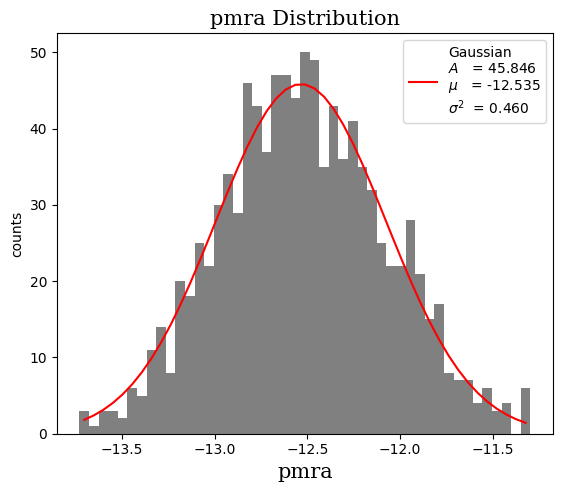

pmra_mean = -12.5354


In [132]:
pmra = aps.pmra
pmra_kde = grasp.plots.histogram(pmra, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmra_mean = pmra_kde[1]
print(f"{pmra_mean = :.4f}")

### PMDEC ($\mu_{\delta^*}$) mean

Correctly imported `minpack.lm`.


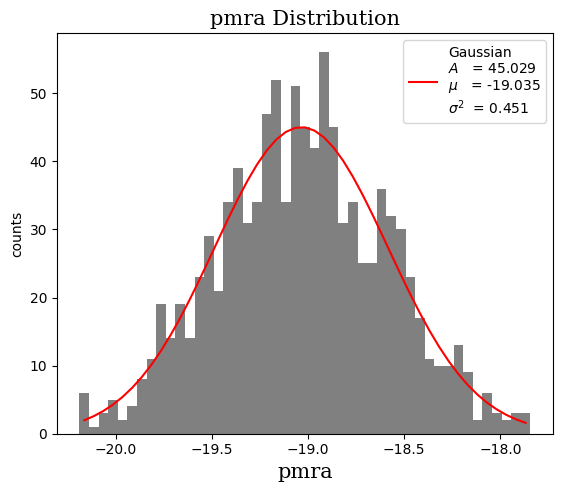

pmdec_mean = -19.0352


In [133]:
pmdec = aps.pmdec
pmdec_kde = grasp.plots.histogram(pmdec, xlabel='pmra', kde=True, kde_kind='gaussian', out=True)['kde']
pmdec_mean = pmdec_kde[1]
print(f"{pmdec_mean = :.4f}")

### Plot try

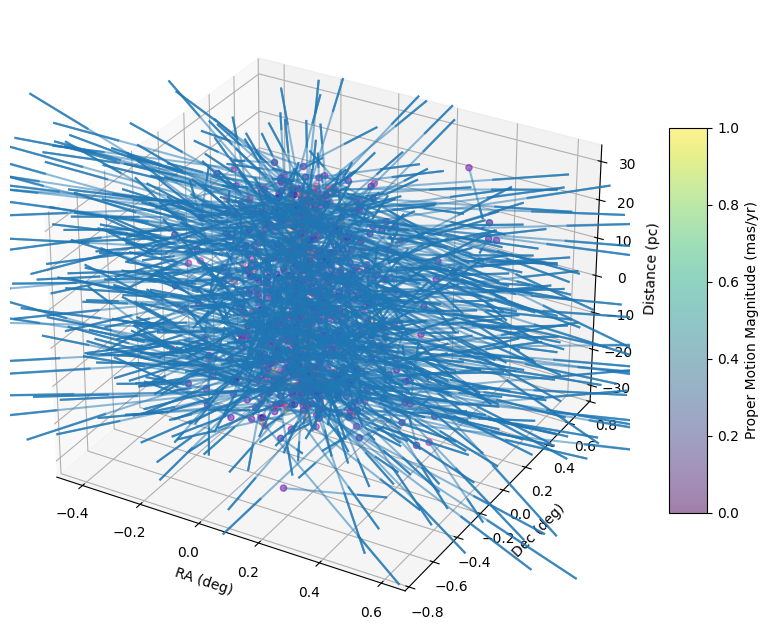

In [131]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.set_xlabel('RA (deg)')
ax.set_ylabel('Dec (deg)')
ax.set_zlabel('Distance (pc)')

# Use X, Y, and d for 3D coordinates
X = aps.ra - gc.ra.value
Y = aps.dec - gc.dec.value
Z = d  # Distance (pc)
accel_x = aps.pmra - pmra_mean
accel_y = aps.pmdec - pmdec_mean
pm = np.sqrt(accel_x**2 + accel_y**2)

Axes3D.scatter3D = ax.scatter(X, Y, Z, c=pm, cmap='plasma', marker='o', alpha=0.5)
# Plot the quiver in 3D
arrows = ax.quiver(X, Y, Z, accel_x, accel_y, np.zeros_like(accel_x), alpha=0.5)

# Add a color bar
cbar = fig.colorbar(arrows, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('Proper Motion Magnitude (mas/yr)')

In [123]:
d

array([ -9.30399379,  -7.76036181,  20.60960271, ...,  -7.99112233,
       -22.77688117, -25.54974494])